In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt  # plotting 1
import seaborn as sns # plotting 2
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

###### First View

In [3]:
os.chdir(r"C:\Data\Илья\DataScience\Kaggle\House_Price\Input")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


### Data Processing

###### Outliers

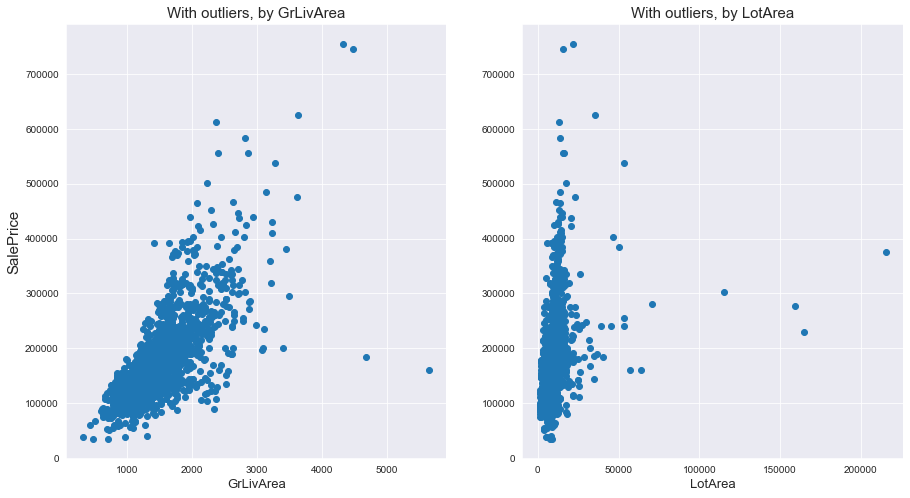

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

#GrLivArea: Above grade (ground) living area square feet
ax1.scatter(x = train.GrLivArea, y = train.SalePrice)
ax1.set_ylabel('SalePrice', fontsize=15)
ax1.set_xlabel('GrLivArea', fontsize=13)
ax1.set_title('With outliers, by GrLivArea', fontsize=15)

#LotArea: Lot size in square feet
ax2.scatter(x = train.LotArea, y = train.SalePrice)
ax2.set_xlabel('LotArea', fontsize=13)
ax2.set_title('With outliers, by LotArea', fontsize=15);

In [6]:
#Deleting outliers
out_indexes =  train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index
train = train.drop(out_indexes)
print('Data with following indexes were dropped:', out_indexes)

Data with following indexes were dropped: Int64Index([523, 1298], dtype='int64')


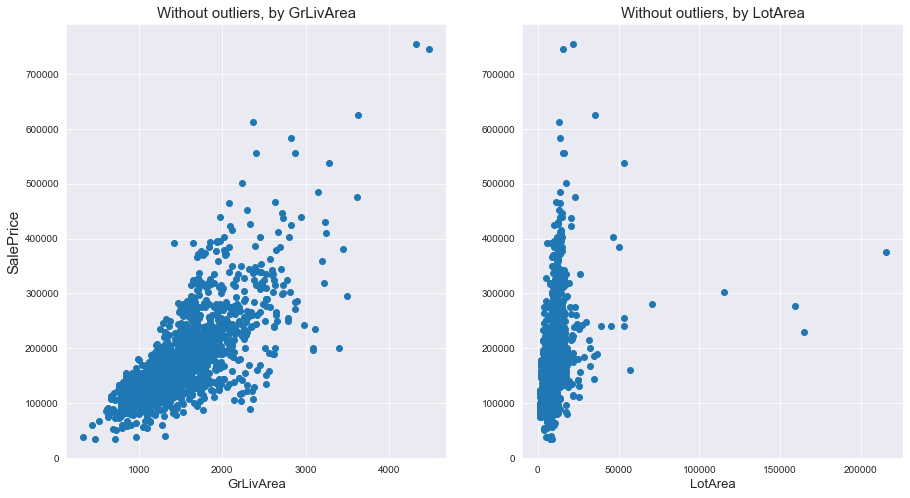

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

ax1.scatter(x = train.GrLivArea, y = train.SalePrice)
ax1.set_ylabel('SalePrice', fontsize=15)
ax1.set_xlabel('GrLivArea', fontsize=13)
ax1.set_title('Without outliers, by GrLivArea', fontsize=15)

ax2.scatter(x = train.LotArea, y = train.SalePrice)
ax2.set_xlabel('LotArea', fontsize=13)
ax2.set_title('Without outliers, by LotArea', fontsize=15);

### Target Variable

mu = 180932.92 and sigma = 79467.79


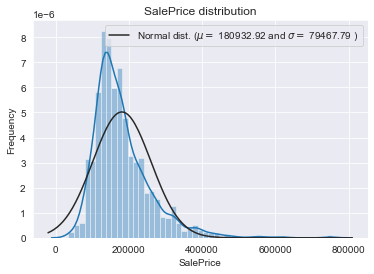

In [8]:
sns.distplot(train.SalePrice , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train.SalePrice)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
#   $\mu=$, $\sigma=$  - для отображения значков мю и сигма

plt.ylabel('Frequency')
plt.title('SalePrice distribution');

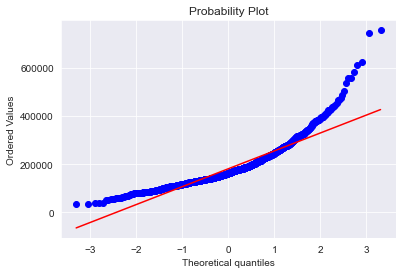

In [9]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(train.SalePrice, plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

###### Log-transformation of the target variable

In [10]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train.SalePrice = np.log1p(train.SalePrice)

mu = 12.02 and sigma = 0.40


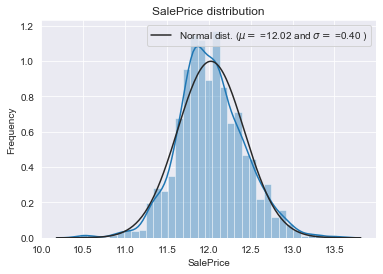

In [11]:
#Check the new distribution 
sns.distplot(train.SalePrice , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train.SalePrice)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ ={:.2f} and $\sigma=$ ={:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution');

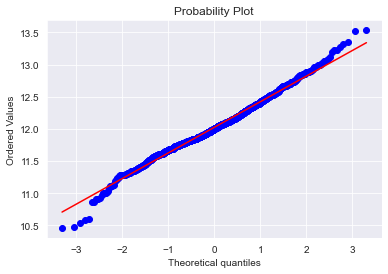

In [12]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(train.SalePrice, plot=plt)
plt.show()

The skew seems now corrected and the data appears more normally distributed.

### Features engineering

In [13]:
ntrain = train.shape[0]  # нужно для того чтобы после преобразований разделить all_data обратно на train & test

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


###### Missing Data

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
fulldata_column_index = all_data_na[all_data_na == 0].index
all_data_na = all_data_na.drop(fulldata_column_index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


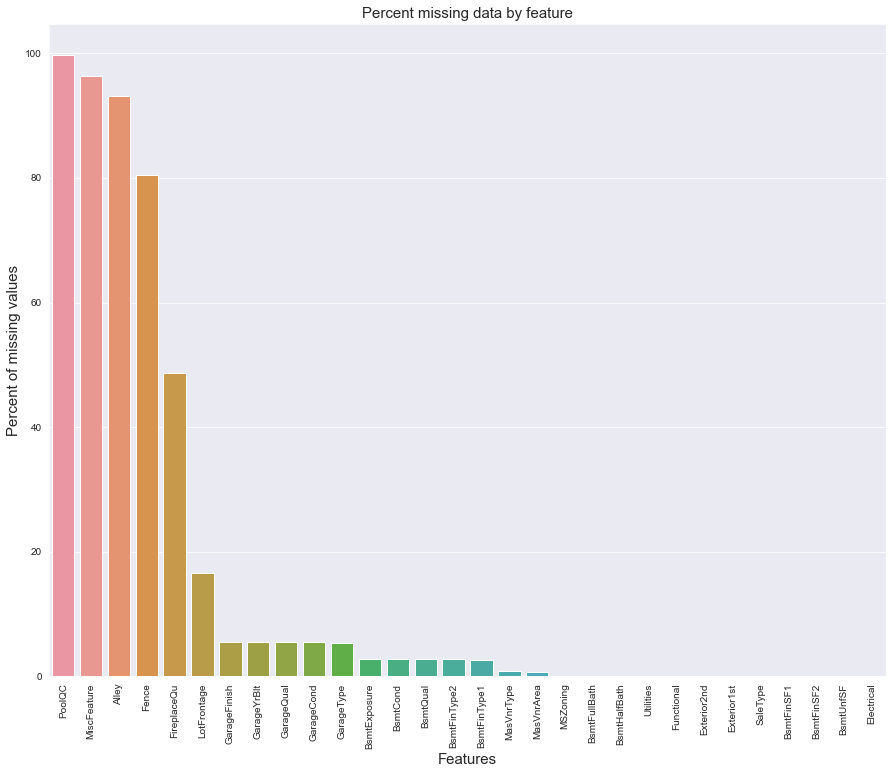

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

###### Data Correlation

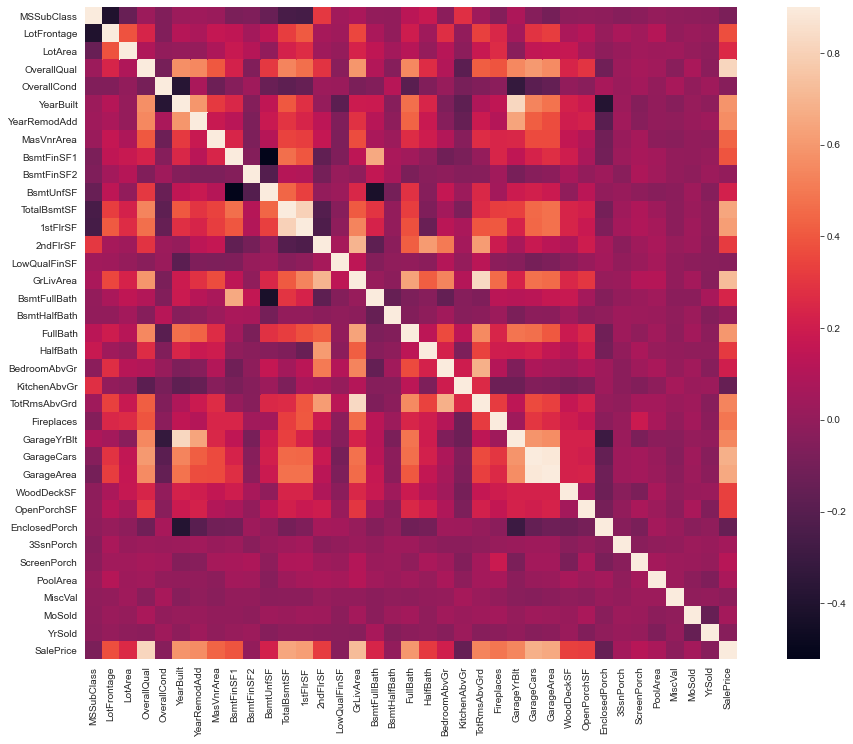

In [16]:
corrmat = train.corr()
plt.subplots(figsize=(18,12))
sns.heatmap(corrmat, vmax=0.9, square=True);

###### Imputing missing values

In [17]:
all_data.PoolQC = all_data.PoolQC.fillna("None")
all_data.MiscFeature = all_data.MiscFeature.fillna("None")
all_data.Alley = all_data.Alley.fillna("None")
all_data.Fence = all_data.Fence.fillna("None")
all_data.FireplaceQu = all_data.FireplaceQu.fillna("None")

In [18]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [19]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [20]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### More features engeneering

###### Transforming some numerical variables that are really categorical

In [21]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

###### Label Encoding some categorical variables that may contain information in their ordering set

In [22]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


###### Adding one more important feature

In [23]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

###### Skewed features

In [24]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


###### Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.

In [25]:
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 36 skewed numerical features to Box Cox transform


###### Getting dummy categorical features

In [26]:
all_data = pd.get_dummies(data= all_data, drop_first=True)
print(all_data.shape)

(2917, 200)


###### Getting the new train and test sets

In [27]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### Modelling

In [28]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [29]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [30]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [31]:
#LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(train, y_train)
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1130 (0.0061)



In [32]:
#Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(train, y_train)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1130 (0.0062)



In [33]:
#Kernel Ridge Regression :
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(train, y_train)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1769 (0.0035)



In [34]:
#Gradient Boosting Regression :
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
GBoost.fit(train, y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1170 (0.0075)



In [35]:
#XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
model_xgb.fit(train, y_train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[13:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:547: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:547: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:547: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XG

In [36]:
#LightGBM :
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
model_lgb.fit(train, y_train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

### Final Prediction

In [37]:
#Top1 is Gradient Boosting Regression (98,5%)

GBoost.fit(train, y_train)
GBoost_train_pred = GBoost.predict(train)
print(GBoost.score(train, y_train))
print(rmsle(y_train, GBoost_train_pred))

# test prediction by GBoost:
GBoost_pred = np.expm1(GBoost.predict(test))

0.9851550395431051
0.048684265515366365


In [38]:
#Top2 is Kernel Ridge Regression (98,0%)

KRR.fit(train, y_train)
KRR_train_pred = KRR.predict(train)
print(KRR.score(train, y_train))
print(rmsle(y_train, KRR_train_pred))

# test prediction by KRR:
KRR_pred = np.expm1(KRR.predict(test))

0.9799134269768872
0.05663071224045209


### Submission

In [39]:
os.chdir(r"C:\Data\Илья\DataScience\Kaggle\House_Price\Output")
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = GBoost_pred
sub.to_csv('submission.csv',index=False)